---

title: "高斯混合模型"
date: 2024-11-21
author: 郝鸿涛
slug: gmm
draft: false
toc: true
tags: 统计

---

## 混合分布

假设一所艺术类高校测量了一千名学生的身高。男生占 40%，其平均身高为 175cm，标准差为 7cm。女生占 60%，平均身高为 162cm，标准差为 6cm。

把数据合并，我们看看最后的直方分布：

In [20]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.stats import norm
import json

np.random.seed(42)

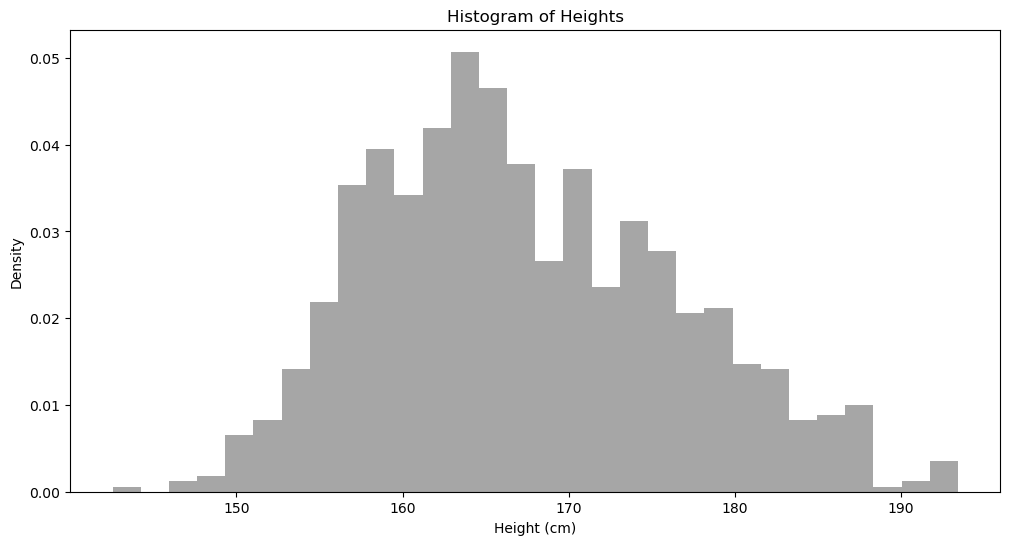

In [21]:
#| code-fold:true

n_female = 600
mu_female = 162
sd_female = 6
n_male = 1000 - n_female
mu_male = 175
sd_male = 7

female_heights = np.random.normal(mu_female, sd_female, n_female)
male_heights = np.random.normal(mu_male, sd_male, n_male)
heights = np.concatenate([female_heights, male_heights])
np.random.shuffle(heights)

plt.figure(figsize=(12, 6))
plt.hist(heights, bins = 30, density=True, alpha=0.7, color='gray')
plt.title('Histogram of Heights')
plt.xlabel("Height (cm)")
plt.ylabel("Density")
plt.show()

我们看到，上面的分布大概有两个峰顶，一个在女生平均身高，另一个在男生平均身高。

混合在一起的身高分布可以用「高斯混合模型」(Gaussian Mixture Model) 来描述：

$$0.4 * \mathcal{N}(175, 7^2) + 0.6 * \mathcal{N}(162, 6^2)$$

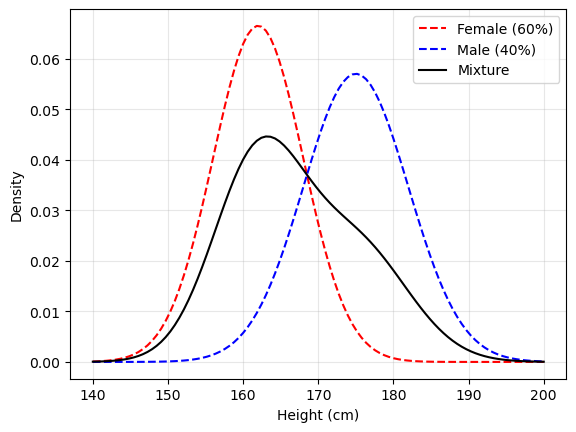

In [22]:
#| code-fold:true

x = np.linspace(140, 200, 100)
female_dist = norm.pdf(x, mu_female, sd_female)
male_dist = norm.pdf(x, mu_male, sd_male)
plt.plot(x, female_dist, 'r--', label="Female (60%)")
plt.plot(x, male_dist, 'b--', label="Male (40%)")
plt.plot(x, 0.6*female_dist + 0.4*male_dist, 'k-', label="Mixture")
plt.xlabel("Height (cm)")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## E-M  算法

假设现在我只把一千名学生的身高数据给你了，但是不知道男、女生各自的比例，也不知道各组的分布参数（平均值、标准差）。请问，如何把男女比例以及各组的分布参数求出来？

我们的思路大概是这样：

- 我们可以根据常识先预设一下男女身高的分布参数，比如，男生平均 173，标准差 5，女生平均 165，标准差 4.5。男女各占 50%。

- 有了初始的值之后，每一个身高，我们可以求出此身高在男女各自高斯分布中的密度值，乘以各自所占比例，然后归一化，就是该身高落在男女各组的概率。这里所用到的是 $P(G|H) \propto P(G)P(H|G)$

- 然后用上面算出的两组数更新男女比例，以及用加权平均公式来更新男女各组的平均值和标准差。

- 如此反复。

In [23]:
def em_algo(heights, initial_means, initial_stds, n_iter = 100):
    mean1, mean2 = initial_means 
    std1, std2 = initial_stds
    pi1 = pi2 = 0.5

    history = []

    history.append({
            'iteration': 0,
            'mean1': mean1,
            'mean2': mean2,
            'std1': std1,
            'std2': std2,
            'pi1': pi1,
            'pi2': pi2
        })

    for iter in range(n_iter):
        prob1 = norm.pdf(heights, mean1, std1)*pi1
        prob2 = norm.pdf(heights, mean2, std2)*pi2

        # responsibility
        resp1 = prob1/(prob1+prob2)
        resp2 = prob2/(prob1+prob2)

        pi1 = np.mean(resp1)
        pi2 = np.mean(resp2)

        mean1 = np.sum(resp1*heights)/np.sum(resp1)
        mean2 = np.sum(resp2*heights)/np.sum(resp2)

        std1 = np.sqrt(np.sum(resp1 * (heights - mean1)**2) / np.sum(resp1))
        std2 = np.sqrt(np.sum(resp2 * (heights - mean2)**2) / np.sum(resp2))

        history.append({
            'iteration': iter + 1,
            'mean1': mean1,
            'mean2': mean2,
            'std1': std1,
            'std2': std2,
            'pi1': pi1,
            'pi2': pi2
        })

    return history

In [24]:
res = em_algo(
    heights, 
    initial_means = [173, 165], 
    initial_stds = [5, 4.5], 
    n_iter = 100
)

In [25]:
res[-1]

{'iteration': 100,
 'mean1': 174.98737549406312,
 'mean2': 161.59379516925364,
 'std1': 7.155329609964584,
 'std2': 5.570256355396785,
 'pi1': 0.42928333161106164,
 'pi2': 0.5707166683889384}

我们看到，这个已经很接近了。让我们把 iteration 增加一下：

In [26]:
res = em_algo(
    heights, 
    initial_means = [173, 165], 
    initial_stds = [5, 4.5], 
    n_iter = 1000
)

In [27]:
res[-1]

{'iteration': 1000,
 'mean1': 174.89513198090734,
 'mean2': 161.5536415719893,
 'std1': 7.193088560338676,
 'std2': 5.553978958610935,
 'pi1': 0.4339690847005224,
 'pi2': 0.5660309152994776}

好像并没有好到哪里去。

那我们想，如果初始值非常不靠谱呢？结果会怎么样？

In [28]:
res = em_algo(
    heights, 
    initial_means = [199, 177], 
    initial_stds = [10, 9], 
    n_iter = 100
)

In [29]:
res[-1]

{'iteration': 100,
 'mean1': 176.84518000880422,
 'mean2': 162.49234107631176,
 'std1': 6.421576228504393,
 'std2': 5.971350004395543,
 'pi1': 0.33798852615801583,
 'pi2': 0.6620114738419841}

我们看到，结果依然不错。

## E-M 算法背后的数学原理

E-M 算法很好理解，但是我们怎么知道随着迭代次数的增加，结果越来越好呢？这就需要数学证明。

这部分我只懂了一部分而已。下面我把我懂的部分解释一下。

对于一个单独的身高 $x_i$，其发生的概率是：

$$P(x_i) = \pi_1 \cdot \mathcal{N}(x_i | \mu_1, \sigma_1^2) + \pi_2 \cdot \mathcal{N}(x_i | \mu_1, \sigma_2^2)$$

我们引入一个「隐变量」$z$，表示 $x_i$ 来自哪个分布。上面的公式等价于

$$P(x_i | \theta) = \sum_{z} P(x_i | z, \theta) P(z | \theta)$$

这里需要理解的是 $z$ 与 $\pi_1, \pi_2$ 不同，因为 $z$ 是对于每一个身高来说的，而$\pi_1, \pi_2$是对于所有身高来说的。

因为每个身高数据是独立的，所以 $P(X|\theta)$ 是一个联合概率：

$$P(x_i | \theta) = \prod_{i=1}^{n} \sum_{z} P(x_i | z, \theta) P(z | \theta)$$

为了便于计算，也为了防止数字下溢，我们取对数，这样就把连乘转化为加法：

$$\log P(x_i | \theta) = \sum_{i=1}^n \log \left(\sum_{z} P(x_i | z, \theta) P(z | \theta)\right)$$

我们把上面的公式称为「对数似然」。我们的目标是找到一组 $\theta$ 让对数似然最大化，这也代表着概率最大，也就是说当参数为 $\theta$ 是，这些身高数据被我们观测到的概率最大。

但是这个优化起来，以我们现有的技术，是非常困难的。因为 $\log\left(\sum_z \right)$ 没办法直接优化。另外，$z$ 是未知的，也让这个求解非常困难。

剩下的我就不太懂了。之后再学吧。